# Simulate BESS
This is a code to simulate the use of Batteries to reduce the electricity price of an industry/consumer
- We are using PyPSA as the optimizer package and
- We simplify the generation by using the marginal price of electricity documented by SMARD: https://www.smard.de/home/downloadcenter/download-marktdaten/
- The technology data can be found in here: https://github.com/PyPSA/technology-data
- We are just using default data, but with the insights of real batteries, we can potentially have a clearer results for optimization
- The load demand is arbitary, for now we set a constant value by default

## Data preparation

In [229]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt

In [230]:
def extract_market_price(years):

    results = pd.DataFrame()
    for year in years:
        market_price = pd.read_csv(
            f"SMARD_market_price_{year}.csv",
            sep=';',
            decimal=',',           # If numbers use comma as decimal point
            parse_dates=True,      # If there are date columns
            dayfirst=True          # If dates are in DD.MM.YYYY format
        )
        market_price["Datum von"] = pd.to_datetime(market_price["Datum von"], format="%d.%m.%Y %H:%M")
        market_price["Datum bis"] = pd.to_datetime(market_price["Datum bis"], format="%d.%m.%Y %H:%M")
        
        de_price = market_price[["Datum von","Deutschland/Luxemburg [€/MWh] Originalauflösungen"]]
        de_price.columns = ["DE Electricity Market",f"market_price_{year}"]
        de_price = de_price.set_index("DE Electricity Market")
        
        # Drop leap days (Feb 29)
        de_price = de_price[~((de_price.index.month == 2) & (de_price.index.day == 29))]

        # ✅ Reset the year to 2025 for all timestamps
        de_price.index = de_price.index.map(lambda dt: dt.replace(year=2025))

        # remove duplicate index
        de_price = de_price.groupby(de_price.index).mean()

        results = pd.concat([results,de_price], axis = 1)

    # Fill nan values
    results = results.interpolate(method="linear")
    
    return results

years = [2019, 2020, 2021, 2022, 2023, 2024]

market_price = extract_market_price(years)
market_price_25 = extract_market_price([2025])

market_price = pd.concat([market_price,market_price_25], axis=1)

market_price.to_csv("market_price.csv")

## Running the simple optimization

In [231]:
def optimize_simple_model(market_price_series, add_battery=True, **kwarg):

    # Create a new empty network
    n = pypsa.Network()
    
    n.set_snapshots(market_price_series.index)
    
    # Add a single bus (e.g. "DE")
    n.add("Bus", "DE")
    
    # Add a generator connected to that bus
    n.add("Generator",
          "DE Electricity Market",
          bus="DE",
          p_nom_extendable=True,
          marginal_cost=market_price_series         # €/MWh
    )
    
    # Add a load connected to the same bus
    n.add("Load",
          "Industry",
          bus="DE",
          p_set=kwarg["Load"]["p_set"]              # Fixed demand (MW)
    )

    if add_battery:
        # Add a battery
        n.add("StorageUnit",
              "BESS",
              bus="DE",
              p_nom=kwarg["StorageUnit"]["p_nom"],  # Fixed capacity (MW)
              max_hours=kwarg["StorageUnit"]["max_hours"], 
              marginal_cost=kwarg["StorageUnit"]["marginal_cost"],
             )
    
    # Optional: run linear optimal power flow (LOPF)
    n.optimize()
    
    # View results
    state_of_charge = n.storage_units_t.state_of_charge["BESS"]
    system_cost = n.objective / 1e6 # Mil €/a

    return state_of_charge, system_cost

def simulate_myopic_optimization(market_price, years, current_date, **kwarg):

    current_date = pd.to_datetime(current_date)
    day_ahead = current_date + pd.Timedelta(days=1)
    week_ahead = current_date + pd.Timedelta(days=7)

    state_of_charge = pd.DataFrame()
    system_cost = {}
    
    for year in years:
        # Extract relevant slices
        recent_prices = market_price.loc[market_price.index <= day_ahead, f"market_price_{current_date.year}"]
        future_prices = market_price.loc[market_price.index > day_ahead, f"market_price_{year}"]
        
        # Combine them into one consistent Series
        market_price_series = pd.concat([recent_prices, future_prices]).sort_index()
        
        state_of_charge_year, system_cost_year = optimize_simple_model(market_price_series, **kwarg)

        state_of_charge = pd.concat([state_of_charge, state_of_charge_year], axis=1)
        system_cost[year] = system_cost_year

    return state_of_charge[current_date:week_ahead], system_cost

In [232]:

# You can set whatever capacity you want
kwarg = {
    "Load":{
        "p_set":50 # in MW
    },
    "StorageUnit":{
        "p_nom":10, # in MW (better less than load)
        "max_hours":8, # in hours
        "marginal_cost":0.1 # in €/MW
    },
}

market_price = pd.read_csv("market_price.csv", parse_dates=True, index_col=0)
years = [2019, 2020, 2021, 2022, 2023, 2024]

state_of_charge, system_cost = simulate_myopic_optimization(
    market_price, 
    years, 
    "2025-09-01", 
    **kwarg
)


Index(['DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 115.45it/s]
INFO:linopy.io: Writing time: 0.31s


Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-gv7je3ev has 87601 rows; 35041 cols; 140160 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e-02, 6e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 8e+01]
Presolving model
17456 rows, 34976 cols, 61127 nonzeros  0s
Dependent equations search running on 8759 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
8759 rows, 26278 cols, 35036 nonzeros  0s
Presolve : Reductions: rows 8759(-78842); columns 26278(-8763); elements 35036(-105124)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      11707     2.9363323700e+07 Pr: 0(0); Du: 0(4.44089e-16) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-gv7je3ev
Model status        : Optimal
S

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35041 primals, 87601 duals
Objective: 2.94e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 107.22it/s]
INFO:linopy.io: Writing time: 0.33s


Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-ao4v7xv4 has 87601 rows; 35041 cols; 140160 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e-02, 6e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 8e+01]
Presolving model
17456 rows, 34976 cols, 61127 nonzeros  0s
Dependent equations search running on 8759 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
8759 rows, 26278 cols, 35036 nonzeros  0s
Presolve : Reductions: rows 8759(-78842); columns 26278(-8763); elements 35036(-105124)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      11663     2.9826377000e+07 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-ao4v7xv4
Model status        : Optimal
Simplex   iterations:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35041 primals, 87601 duals
Objective: 2.98e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 112.22it/s]
INFO:linopy.io: Writing time: 0.32s


Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-e6hm1b07 has 87601 rows; 35041 cols; 140160 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e-02, 6e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 8e+01]
Presolving model
17456 rows, 34976 cols, 61127 nonzeros  0s
Dependent equations search running on 8759 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
8759 rows, 26278 cols, 35036 nonzeros  0s
Presolve : Reductions: rows 8759(-78842); columns 26278(-8763); elements 35036(-105124)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      11712     4.7524309900e+07 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-e6hm1b07
Model status        : Optimal
Simplex   iterations:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35041 primals, 87601 duals
Objective: 4.75e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['DE'], dtype='object', name='Bus')


Writing the solution to /tmp/linopy-solve-erbx764u.sol


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 113.48it/s]
INFO:linopy.io: Writing time: 0.31s


Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-xuemzhvc has 87601 rows; 35041 cols; 140160 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e-02, 6e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 8e+01]
Presolving model
17447 rows, 34967 cols, 61100 nonzeros  0s
Dependent equations search running on 8759 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
8759 rows, 26278 cols, 35036 nonzeros  0s
Presolve : Reductions: rows 8759(-78842); columns 26278(-8763); elements 35036(-105124)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      11667     3.6236163750e+07 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-xuemzhvc
Model status        : Optimal
Simplex   iterations:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35041 primals, 87601 duals
Objective: 3.62e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['DE'], dtype='object', name='Bus')


Writing the solution to /tmp/linopy-solve-9umv6mml.sol


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 122.56it/s]
INFO:linopy.io: Writing time: 0.3s


Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-1spyse7h has 87601 rows; 35041 cols; 140160 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e-02, 6e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 8e+01]
Presolving model
17447 rows, 34967 cols, 61100 nonzeros  0s
Dependent equations search running on 8759 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
8759 rows, 26278 cols, 35036 nonzeros  0s
Presolve : Reductions: rows 8759(-78842); columns 26278(-8763); elements 35036(-105124)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      11667     3.6236163750e+07 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-1spyse7h
Model status        : Optimal
Simplex   iterations:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35041 primals, 87601 duals
Objective: 3.62e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
Index(['DE'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 114.50it/s]
INFO:linopy.io: Writing time: 0.3s


Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-7t02lhv_ has 87601 rows; 35041 cols; 140160 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e-02, 9e+02]
  Bound  [0e+00, 0e+00]
  RHS    [1e+01, 8e+01]
Presolving model
17441 rows, 34961 cols, 61082 nonzeros  0s
Dependent equations search running on 8759 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
8759 rows, 26278 cols, 35036 nonzeros  0s
Presolve : Reductions: rows 8759(-78842); columns 26278(-8763); elements 35036(-105124)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
      11670     3.7621072300e+07 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-7t02lhv_
Model status        : Optimal
Simplex   iterations:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35041 primals, 87601 duals
Objective: 3.76e+07
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


Writing the solution to /tmp/linopy-solve-pnu3xf6q.sol


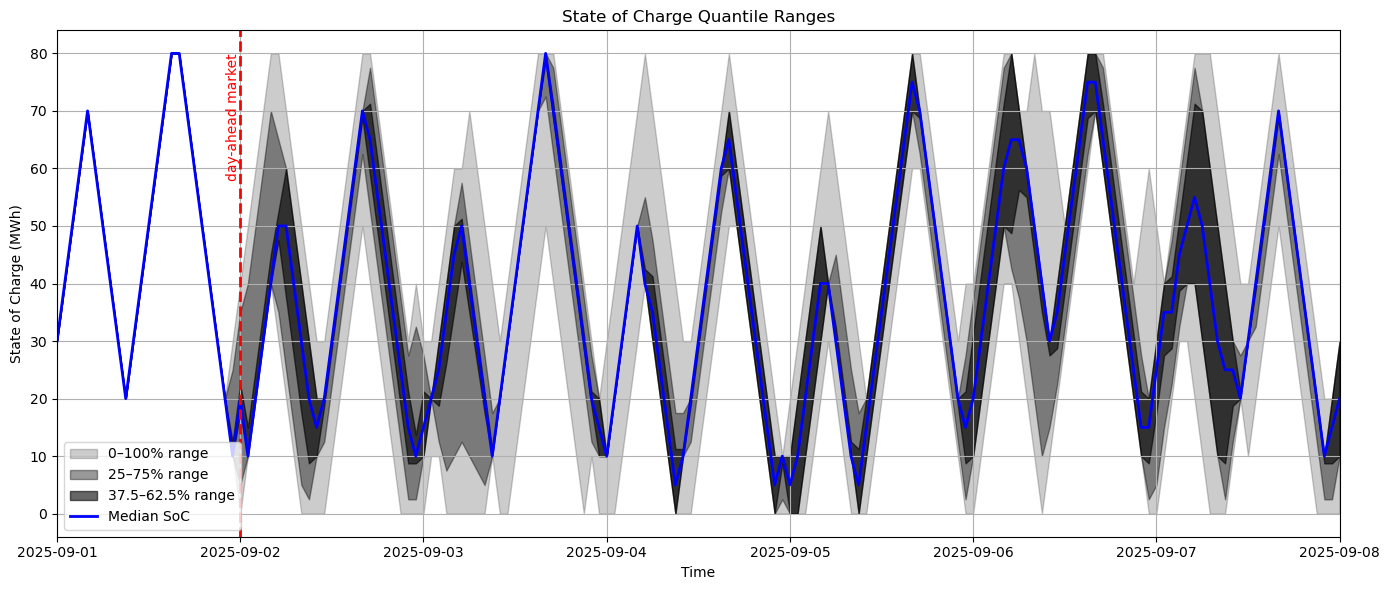

In [233]:
# Calculate percentiles across columns for each timestamp
q_0 = state_of_charge.min(axis=1)  # or .quantile(0.0)
q_25 = state_of_charge.quantile(0.25, axis=1)
q_37 = state_of_charge.quantile(0.375, axis=1)
q_50 = state_of_charge.median(axis=1)
q_62 = state_of_charge.quantile(0.625, axis=1)
q_75 = state_of_charge.quantile(0.75, axis=1)
q_100 = state_of_charge.max(axis=1)  # or .quantile(1.0)

# Start plotting
plt.figure(figsize=(14, 6))

# Lightest area: min to max (0–100%)
plt.fill_between(state_of_charge.index, q_0, q_100, color='black', alpha=0.2, label='0–100% range')

# Medium area: 25–75%
plt.fill_between(state_of_charge.index, q_25, q_75, color='black', alpha=0.4, label='25–75% range')

# Darkest area: 37.5–62.5%
plt.fill_between(state_of_charge.index, q_37, q_62, color='black', alpha=0.6, label='37.5–62.5% range')

# median line
plt.plot(state_of_charge.index, q_50, color='blue', linestyle='-', linewidth=2, label='Median SoC')

# Day-ahead market
day_ahead = pd.to_datetime(current_date) + pd.Timedelta(days=1)
plt.axvline(day_ahead, color='red', linestyle='--', linewidth=2)
plt.text(
    x=day_ahead,
    y=q_100.max(),
    s="day-ahead market",
    color='red',
    rotation=90,
    verticalalignment='top',
    horizontalalignment='right'
)

# Formatting
plt.title("State of Charge Quantile Ranges")
plt.xlabel("Time")
plt.xlim(state_of_charge.index.min(), state_of_charge.index.max())
plt.ylabel("State of Charge (MWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("state_of_charge_plot.png", dpi=300)  # Save to file
plt.show()
